In [21]:
import torch
from diffusers import StableDiffusionPipeline


def load_pipeline(model_or_dir: str, use_gpu: bool = True) -> StableDiffusionPipeline:
    """
    Loads a Stable Diffusion pipeline from either a Hugging Face model name
    or a local directory with finetuned weights.

    Args:
        model_or_dir (str): 
            - A Hugging Face model name, e.g. "stabilityai/stable-diffusion-2-base"
            - or a local directory, e.g. "./sd2-mca-finetuned/final"
        use_gpu (bool):
            If True, tries to use GPU (float16) if available; otherwise CPU (float32).
    
    Returns:
        pipe (StableDiffusionPipeline): The loaded pipeline.
    """

    if use_gpu and torch.cuda.is_available():
        device = "cuda"
        torch_dtype = torch.float16  # efficient on GPUs that support FP16
        print(f"Loading '{model_or_dir}' on GPU with float16 precision.")
    else:
        device = "cpu"
        torch_dtype = torch.float32
        print(f"Loading '{model_or_dir}' on CPU with float32 precision.")

    pipe = StableDiffusionPipeline.from_pretrained(
        model_or_dir,
        torch_dtype=torch_dtype
    )

    pipe = pipe.to(device)

    return pipe


def generate_images(
    pipe: StableDiffusionPipeline,
    prompt: str,
    n_samples: int = 4,
    num_inference_steps: int = 25,
    guidance_scale: float = 7.5
):
    """
    Generates `n_samples` images in parallel (batch inference) for a single prompt.

    Args:
        pipe (StableDiffusionPipeline): Loaded diffusion pipeline (already on device).
        prompt (str): The text prompt for generation.
        n_samples (int): Number of images to generate in one forward pass.
        num_inference_steps (int): Number of diffusion steps (higher -> better quality).
        guidance_scale (float): Classifier-free guidance scale.

    Returns:
        List[PIL.Image.Image]: List of generated images (length = n_samples).
    """
    device = next(pipe.unet.parameters()).device  # infer device from the model

    # Create a list of identical prompts so the pipeline can do parallel inference
    prompts = [prompt] * n_samples

    if device.type == "cuda":
        with torch.autocast("cuda"):
            result = pipe(
                prompts,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale
            )
    else:
        result = pipe(
            prompts,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale
        )

    # The pipeline returns a list of images for each prompt
    generated_images = result.images  # length = n_samples

    return generated_images


import matplotlib.pyplot as plt

def display_images_grid(images, row_size=4, fig_size=(16, 8)):
    """
    Displays a list of PIL images in a matplotlib grid.

    Args:
        images (List[PIL.Image.Image]): The images to display.
        row_size (int): Number of images per row.
        fig_size (tuple): Figure size (width, height) in inches.
    """
    n = len(images)
    rows = (n + row_size - 1) // row_size  # ceil division for total rows

    plt.figure(figsize=fig_size)
    for i, img in enumerate(images):
        plt.subplot(rows, row_size, i+1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


### Visualize a few generated images

Using GPU (CUDA) with float16 precision.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Using GPU (CUDA) with float16 precision.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

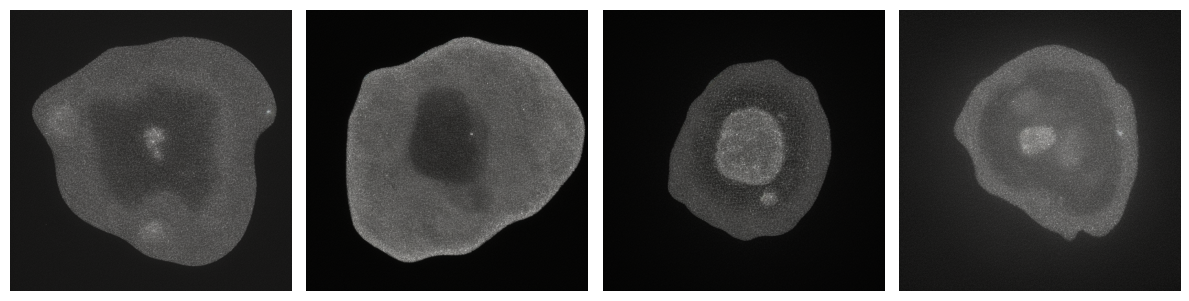

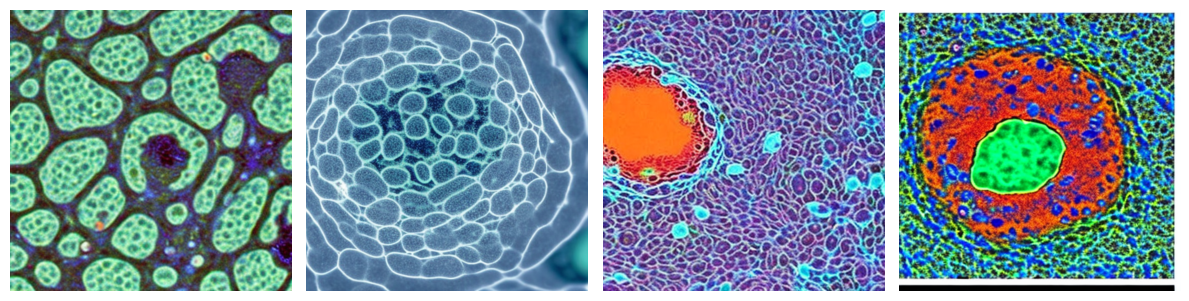

In [22]:
finetuned_pipe = load_finetuned_pipeline("../../sd2-mca-finetuned/final", use_gpu=True)
original_pipe = load_finetuned_pipeline("stabilityai/stable-diffusion-2-base", use_gpu=True)

finetuned_images = generate_images(
    finetuned_pipe,
    prompt="a microscopy image of a cell",
    n_samples=4,
    num_inference_steps=25,
    guidance_scale=7.5
)

original_images = generate_images(
    original_pipe,
    prompt="a microscopy image of a cell",
    n_samples=4,
    num_inference_steps=25,
    guidance_scale=7.5
)

# Display them in 2 rows of 4 columns (since 6 images, 4 columns -> 2 rows)
display_images_grid(finetuned_images, row_size=4, fig_size=(12, 6))
display_images_grid(original_images, row_size=4, fig_size=(12, 6))


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

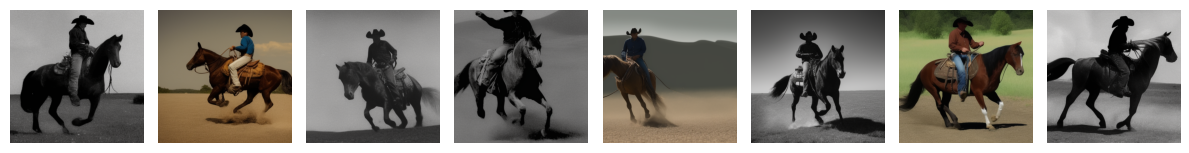

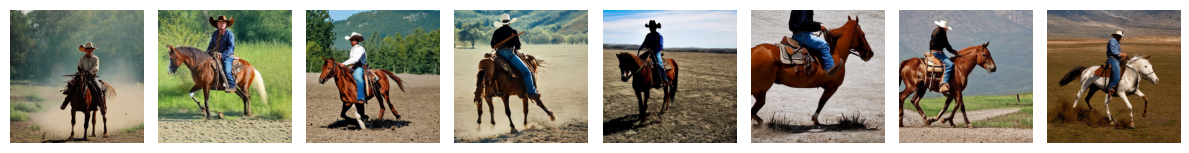

In [23]:
# can we still use normal SD prompts?

finetuned_images = generate_images(
    finetuned_pipe,
    prompt="a cowboy riding on a horse",
    n_samples=8,
    num_inference_steps=25,
    guidance_scale=7.5
)
original_images = generate_images(
    original_pipe,
    prompt="a cowboy riding on a horse",
    n_samples=8,
    num_inference_steps=25,
    guidance_scale=7.5
)


display_images_grid(finetuned_images, row_size=8, fig_size=(12, 6))
display_images_grid(original_images, row_size=8, fig_size=(12, 6))

Clearly a black and white bias on the cowboy images from the finetuned model, which makes sense because we finetuned on black and white cell images!

## Analyze cell images

  0%|          | 0/25 [00:00<?, ?it/s]

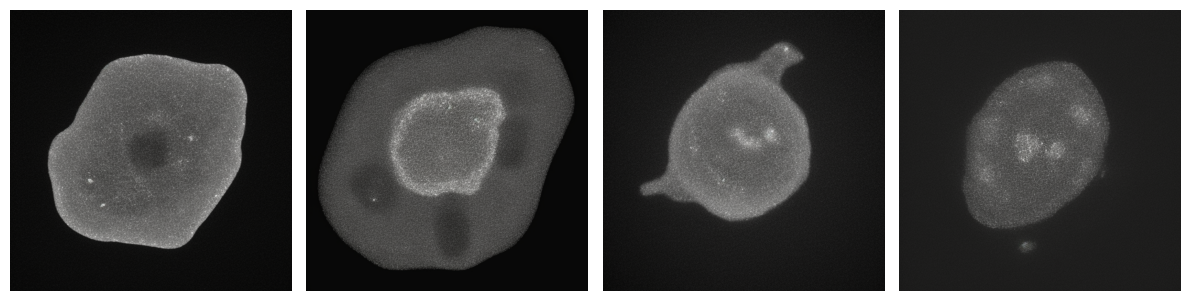

In [25]:
cell_images = generate_images(
    finetuned_pipe,
    prompt="a microscopy image of a cell",
    n_samples=4,
    num_inference_steps=25,
    guidance_scale=7.5
)
display_images_grid(cell_images, row_size=4, fig_size=(12, 6))

In [26]:
print(type(cell_images[0]))
print(cell_images[0].mode)

<class 'PIL.Image.Image'>
RGB


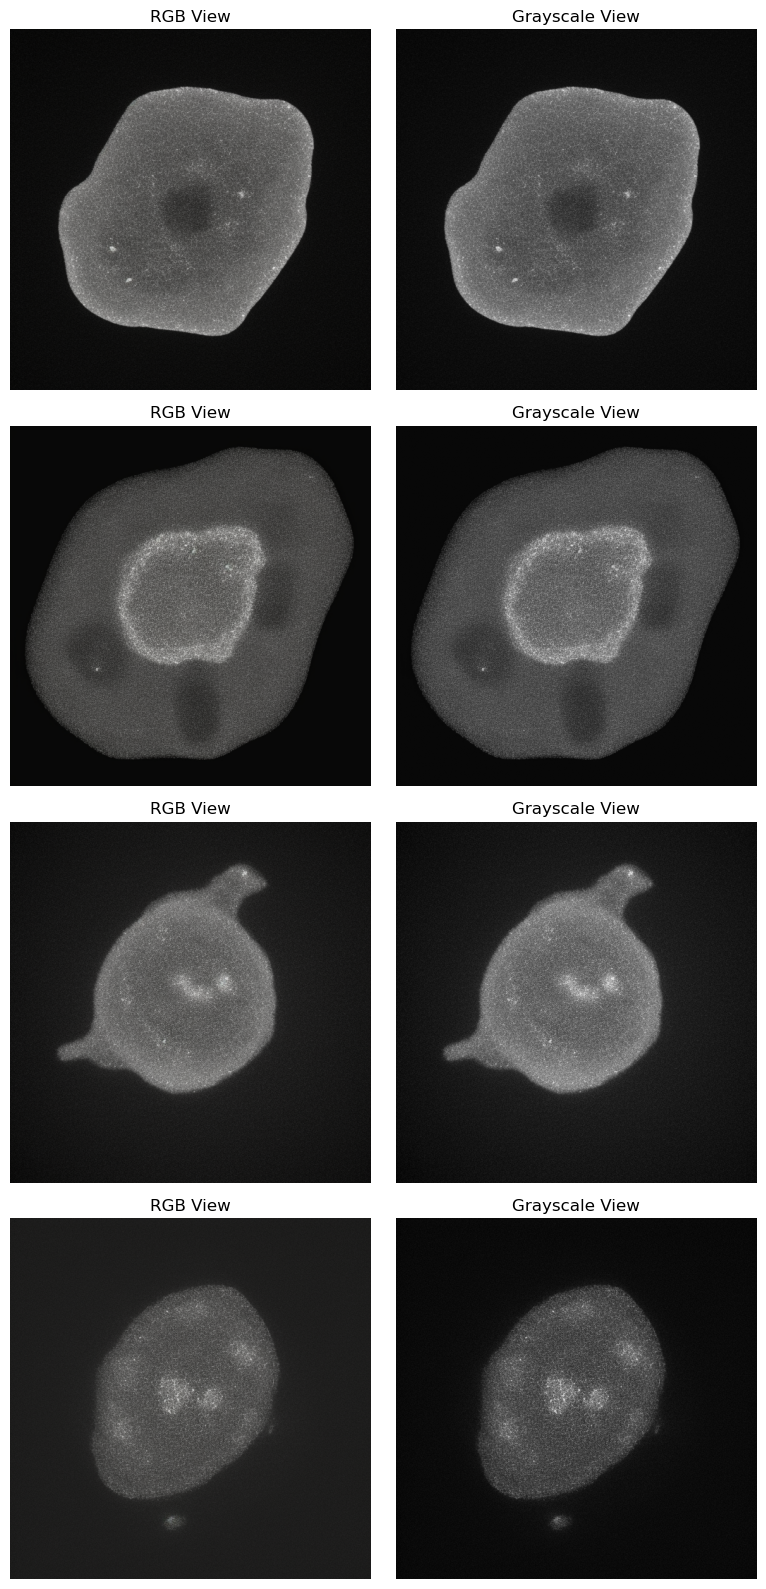

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(cell_images), ncols=2, figsize=(8, 4 * len(cell_images)))

for i, img in enumerate(cell_images):
    # Original (RGB)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("RGB View")
    axes[i, 0].axis("off")
    
    # Convert to grayscale
    img_gray = img.convert("L")
    axes[i, 1].imshow(img_gray, cmap="gray")
    axes[i, 1].set_title("Grayscale View")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [31]:
import numpy as np
from PIL import Image

img = cell_images[0]  # a generated PIL image
arr = np.array(img)   # shape [H, W, 3]
r_channel = arr[..., 0]
g_channel = arr[..., 1]
b_channel = arr[..., 2]

print("R vs. G difference:", np.mean(np.abs(r_channel - g_channel)))
print("G vs. B difference:", np.mean(np.abs(g_channel - b_channel)))
print("R vs. B difference:", np.mean(np.abs(r_channel - b_channel)))


R vs. G difference: 10.782562255859375
G vs. B difference: 3.7818565368652344
R vs. B difference: 1.5761375427246094
